### Graphs for the paper.

31/10/2023 - Using the straight line Wigner kernel, we will compute and graph the Wigner function of various states. The main states to graph are an example of an abelian curve and an example of a non-abelian curve. The expected result is that for the abelian curve we obtain a delta function in the shape of the corresponding curve, while for the none abelian curve we obtain negative components.

In [1]:
import numpy as np
from itertools import product, permutations

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm

In [2]:
N = 3
F = GF(2^3, 'x')
x = F.gen()

# additive group character
chi = lambda k: np.exp(np.pi * 1j * int(k.trace()))

def toInt(k):
    return list(F).index(k)

In [3]:
def Proj(u, v=None):
    if not v:
        v = u
    return np.outer(u, v.conj().T)

Id = np.eye(2^N)

def Fourier():
    s = np.zeros((2^N, 2^N), dtype='complex128')
    for i, a in enumerate(F):
        for j, b in enumerate(F):
            s[i,j] = chi(a * b) / np.sqrt(2^N)
    return s
FF = Fourier()

In [4]:
ps = np.load('phase_space.npy')

In [5]:
Matrix(ps)

[   1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0]
[   1.0   -1.0 -1.0*I    1.0 -1.0*I  1.0*I  1.0*I   -1.0]
[   1.0 -1.0*I   -1.0  1.0*I -1.0*I  1.0*I    1.0   -1.0]
[   1.0    1.0  1.0*I  1.0*I  1.0*I    1.0    1.0  1.0*I]
[   1.0 -1.0*I -1.0*I  1.0*I   -1.0    1.0  1.0*I   -1.0]
[   1.0  1.0*I  1.0*I    1.0    1.0  1.0*I    1.0  1.0*I]
[   1.0  1.0*I    1.0    1.0  1.0*I    1.0  1.0*I  1.0*I]
[   1.0   -1.0   -1.0  1.0*I   -1.0  1.0*I  1.0*I -1.0*I]

Here we calculate the phases directly from the recurrence relation.

In [6]:
basis = [x^3, x^5, x^6] # self-dual basis

In [44]:
# express an element as a linear combination of the basis
components = lambda k: [(k * el).trace() for el in basis]

chi2 = lambda k: exp(pi * I * int(k.trace()))

In [45]:
y = var('y')

# compute the coefficients for the basis elements,
def solve_basis(basis, curve):
    sols = []
    for k in basis:
        sol = solve(chi2(k * curve(k)) == y^2, y, solution_dict=True)
        sols.append(sol[1]) # positive solutions only (choice)
    return sols

In [46]:
# after computing the solutions we can simply
# get them for each basis element.
def basis_c(a, l, sols):
    if a == 0:
        return 1
    return sols[l][y]

In [47]:
# Compute an arbitrary coefficient c_{\alpha,f(\alpha)} for a 
# given curve f using the general formula.
def c(alpha, curve, sols=None):
    if not sols:
        sols = solve_basis(basis, curve)
    
    # Expand alpha in the basis
    comps = components(alpha)

    # Apply the formula
    s1 = 0
    for k in range(N-1):
        s2 = 0
        for j in range(k+1, N):
            s2 += comps[j] * basis[j]
        s1 += s2 * curve(comps[k] * basis[k])
        
    return chi2(s1) * prod([basis_c(a, l, sols) for l, a in enumerate(comps)])

In [48]:
def sign_perm(sols, perm=None):
    if perm:
        for k, sol in enumerate(sols):
            sols[k][y] = perm[k] * sols[k][y]
    return sols

In [49]:
def phi(a, b):
    return ps[toInt(a), toInt(b)]

def Z(a):
    return np.diag([chi(a * k) for k in F])

def X(b):
    return FF.conj().T @ Z(b) @ FF

def D(a, b):
    return phi(a, b) * (Z(a) @ X(b))

The displacement operators should be trace orthogonal, null trace, unitary and hermititan.

In [14]:
# trace orthogonal
for a in F:
    for b in F:
        D1 = D(a, b)
        for c in F:
            for d in F:
                D2 = D(c, d)
                tr = (D1 @ D2.conj().T).trace()
                dl = int(a == c) * int(b == d)
                if not np.isclose(tr, (2^N) * dl):
                    raise Exception(tr, dl, a, b, c, d)

# null trace
for a in F:
    for b in F:
        if a != 0 and b != 0:
            d = D(a, b)
            if not np.isclose(d.trace(), 0):
                raise Exception(a, b)

# hermitian
for a in F:
    for b in F:
        d = D(a, b)
        if not np.allclose(d, d.conj().T):
            raise Exception(a,b)

# unitarity
for a in F:
    for b in F:
        d = D(a,b)
        if not np.allclose(d @ d.conj().T, Id):
            raise Exception

In [15]:
# This is for abelian curves only, 
# i.e., curves for which the phases of the disp
# operators match the DPS
def eig_proj(param, k=F(0)):
    eig = np.zeros((2^N, 2^N), dtype='complex128')
    for tau in F:
        eig += chi(tau * k) * D(*param(tau)) / (2^N)
    return eig

In [16]:
def Wigner(alpha, beta):
    wigner_kernel = np.zeros((2^N, 2^N), dtype='complex128')
    for ga in F:
        for de in F:
            wigner_kernel += chi(ga * beta - de * alpha) * D(ga, de) / 2^N
    return wigner_kernel

In [17]:
def WignerMatrix(state):
    m = np.zeros((2^N, 2^N), dtype='float64')
    for i, a in enumerate(F):
        for j, b in enumerate(F):
            m[i, j] = np.real((Wigner(a, b) @ state).trace())
    return m / 2^N

In [18]:
def W(state, prec=3):
    return np.round(WignerMatrix(state), prec)

Now for some testing.

In [19]:
def points(curve):
    # curve is a paramtrization (a(t), b(t))
    return [curve(tau) for tau in F]

In [20]:
def graph(pts):
    m = zero_matrix(SR, 2^N, 2^N)
    for p in pts:
        m[toInt(p[0]), toInt(p[1])] = 1
    return m

In [21]:
# For a fixed DPS
def testCurve(points):
    for p1 in points:
        for p2 in points:
            p_op = D(*p1) @ D(*p2)
            s_op = D(p1[0] + p2[0], p1[1] + p2[1])
            if not np.allclose(p_op, s_op):
                raise Exception(p1, p2)
    return True

In [22]:
plt.rc('text', usetex=True)
plt.rc('font', family='sans serif')

In [23]:
def PlotWigner(w):
    data_array = w.T

    fig = plt.figure(figsize=(8,8), dpi=400)
    
    ax = fig.subplots(subplot_kw = {'projection' : '3d'})
    ax.set_box_aspect(aspect=(4,4,3), zoom=0.85)
    ax.view_init(elev=30, azim=-45, roll=0)

    x_data, y_data = np.meshgrid(
        np.arange(data_array.shape[1]),
        np.arange(data_array.shape[0])
    )

    x_data = x_data.flatten()
    y_data = y_data.flatten()
    z_data = data_array.flatten()

    ax.set_zlim(min(0, z_data.min()) - 0.00, z_data.max() + 0.05)

    offset = z_data + np.abs(z_data.min())
    fracs  = offset.astype(float) / offset.max()
    norm   = colors.Normalize(fracs.min(), fracs.max())
    color_vals = cm.viridis(norm(fracs.tolist()))

    ax.bar3d(
        x_data,
        y_data,
        np.zeros(len(z_data)),
        0.95, 0.95, z_data,
        color = color_vals
    )

    labels = [r'$0$',r'$\sigma$',r'$\sigma^2$',r'$\sigma^3$',
              r'$\sigma^4$',r'$\sigma^5$',r'$\sigma^6$',r'$\sigma^7$']
    
    plt.xticks(np.arange(8), labels)
    plt.yticks(np.arange(1, 9, 1), labels)

    plt.xlabel(r'$\alpha$', fontsize=20)
    plt.ylabel(r'$\beta$', fontsize=20)
    
    ax.xaxis.set_rotate_label(False)
    ax.yaxis.set_rotate_label(False)
    ax.set_zlabel(r'$W(\alpha,\beta)$', fontsize=20)

    ax.xaxis.labelpad=15
    ax.yaxis.labelpad=15
    ax.zaxis.labelpad=20

    ax.tick_params(axis='x', which='major', labelsize=15)
    ax.tick_params(axis='y', which='major', labelsize=15)

    fig.tight_layout()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=0.9)

    return (fig, ax)

In [24]:
def ray(mu):
    return lambda k: (k, mu * k)

In [25]:
for mu in F:
    testCurve(points(lambda t: (t, mu * t)))

Of course all of the rays are abelian, and so their Wigner functions must be deltas. Now let's see for some other abelian curves. In particular we care about curves from the $(0,9,0)$ bundle:
$$
\alpha = \beta + \sigma^6 \beta^2 + \sigma^3 \beta^4,
\quad
\beta = \alpha + \sigma^3 \alpha^2 + \sigma^5 \alpha^4.
$$

In [26]:
curve1 = lambda b: (b + x^6 * b^2 + x^3 * b^4, b)
curve2 = lambda a: (a, a + x^3 * a^2 + x^5 * a^4)

In [27]:
graph(points(curve1))

[1 0 0 0 1 0 0 0]
[0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0]
[0 0 0 1 0 0 1 0]
[0 0 0 0 0 1 0 1]
[0 0 0 0 0 0 0 0]
[0 1 1 0 0 0 0 0]

In [28]:
w = W(eig_proj(curve1))

/var/folders/04/vcl1jrm14fg9v4p4_s66k4hm0000gn/T/ipykernel_2258/457068485.py:54: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


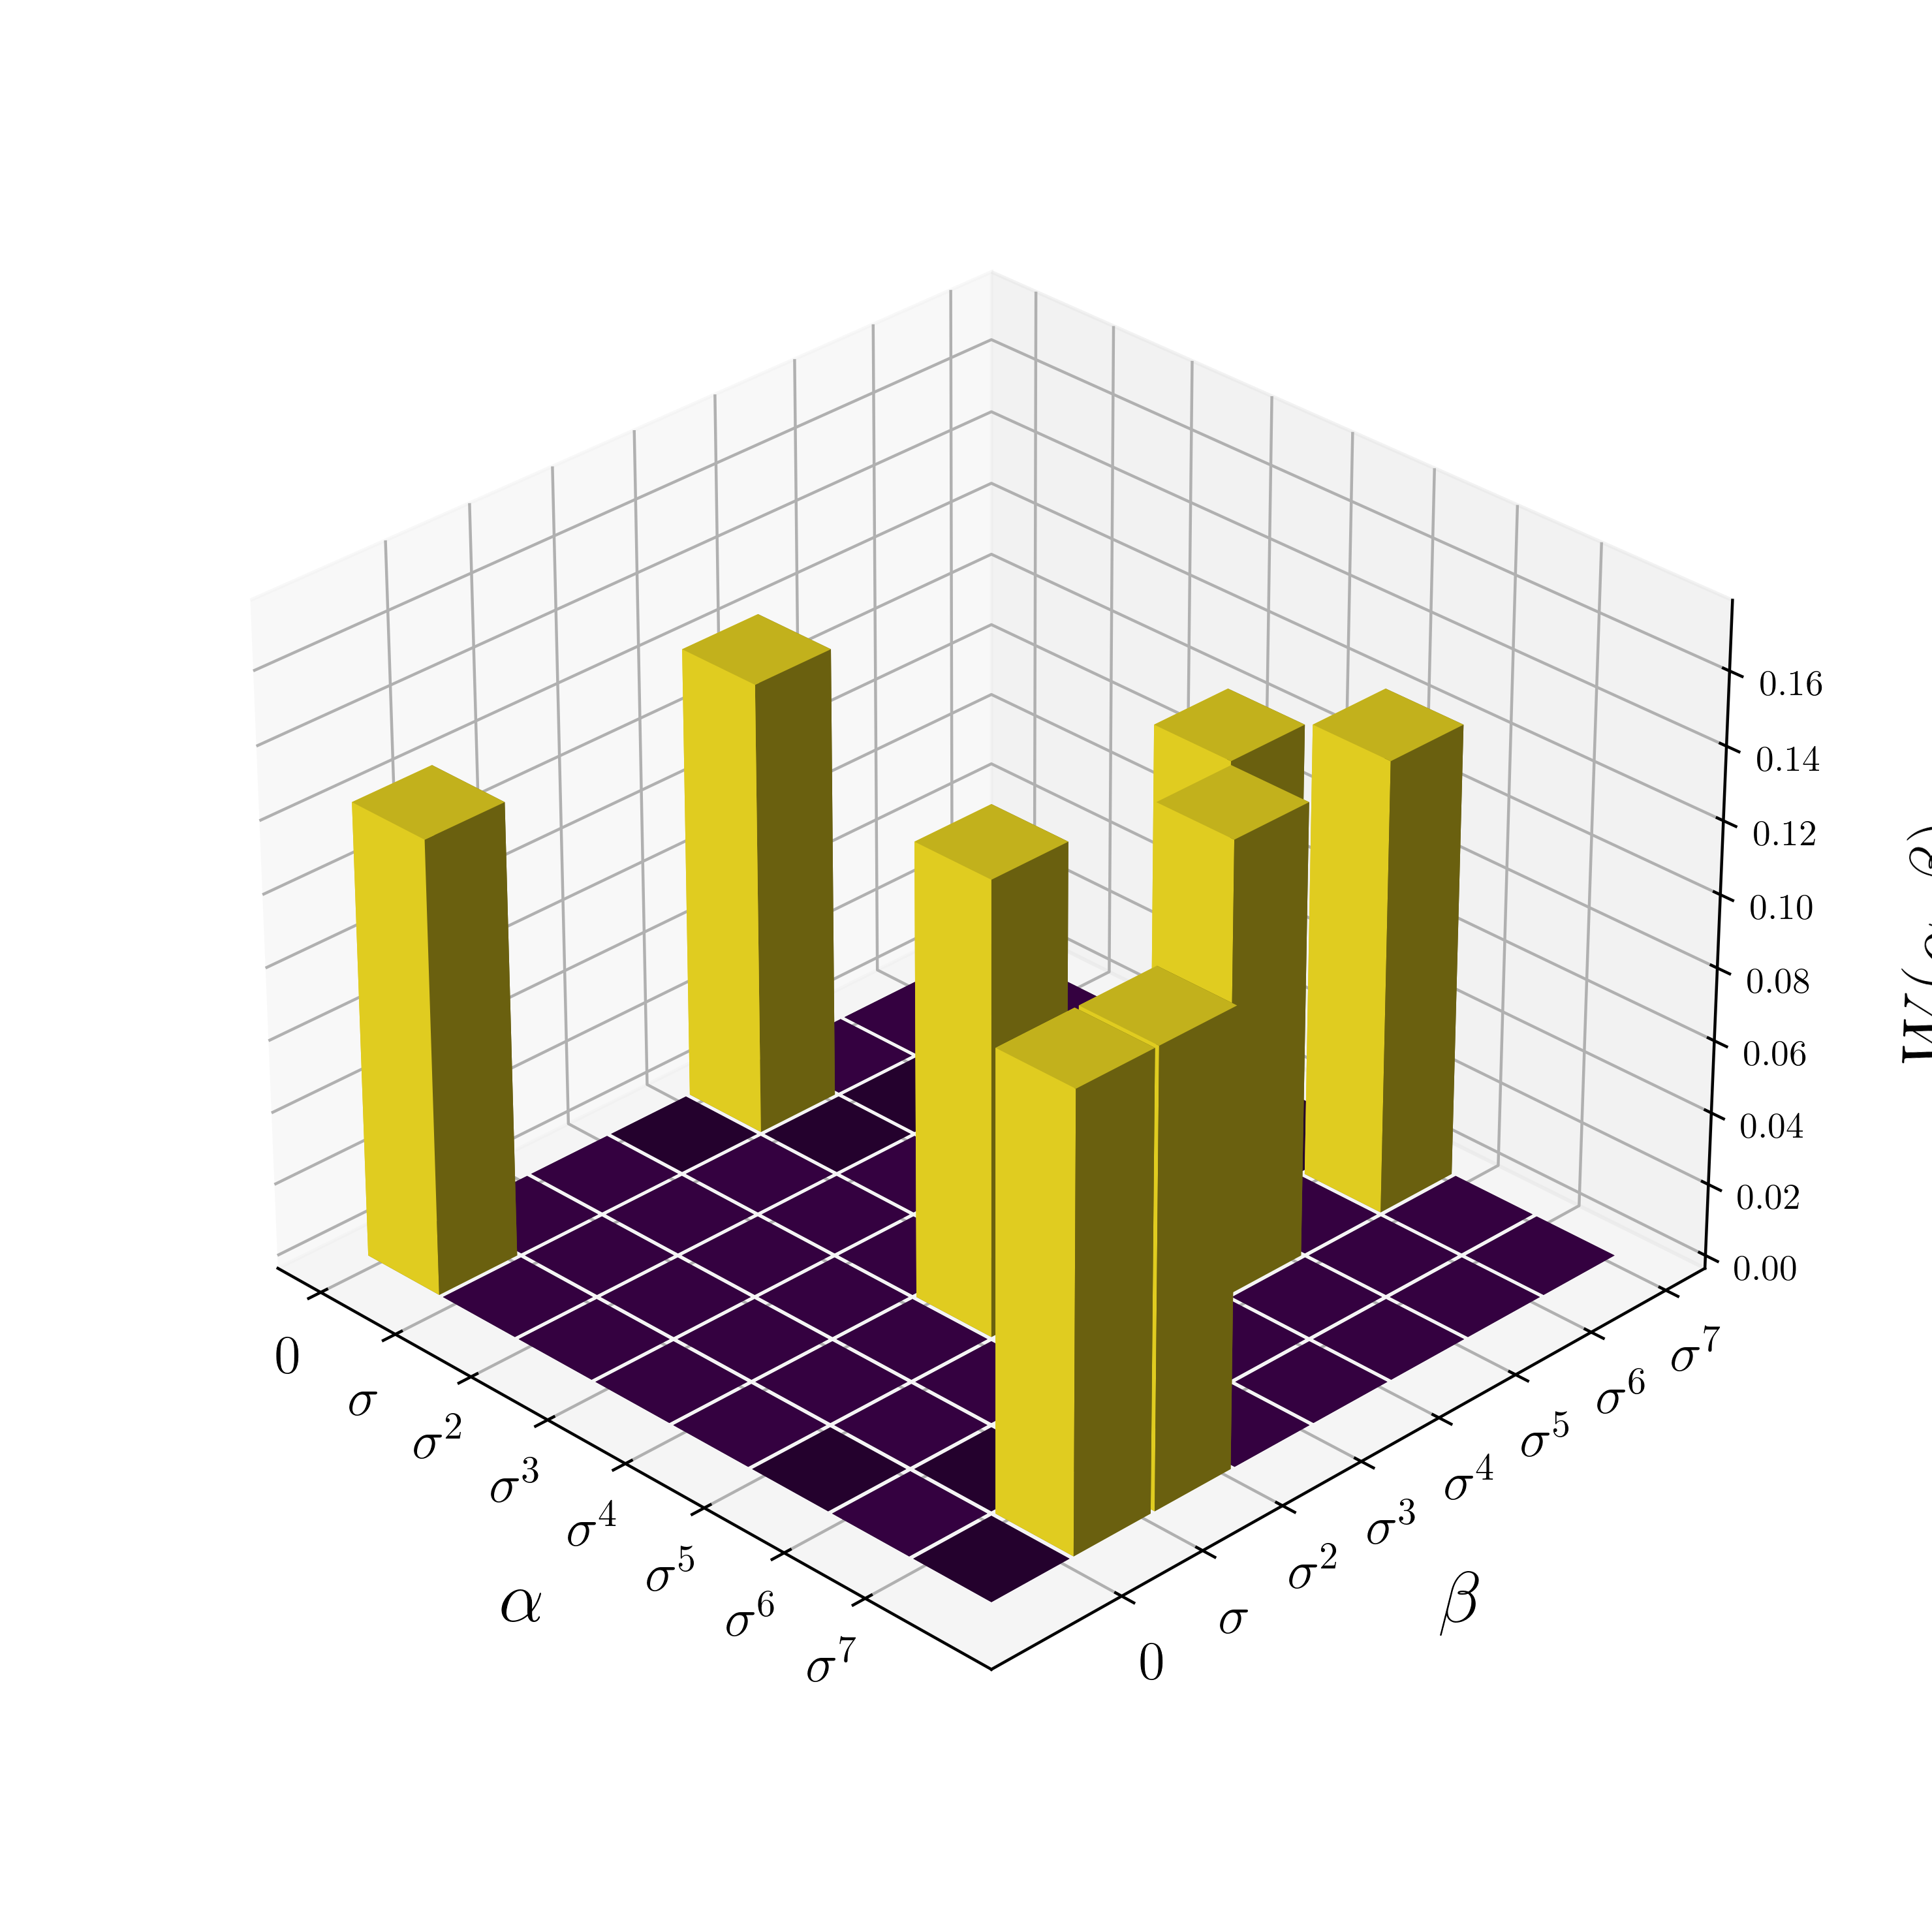

In [29]:
fig, ax = PlotWigner(abs(w))

In [212]:
bbox = fig.bbox_inches.from_bounds(1, 0.5, 7, 6)
fig.savefig('./paper_graphs/abelian_1.eps', format='eps', bbox_inches=bbox)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [30]:
graph(points(curve2))

[1 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 1]
[1 0 0 0 0 0 0 0]
[0 0 1 0 0 0 0 0]
[0 0 0 0 0 0 0 1]
[0 0 1 0 0 0 0 0]
[0 0 0 0 0 0 1 0]
[0 0 0 0 0 0 1 0]

In [31]:
Matrix(np.round(eig_proj(curve2), 3))

[   0.25     0.0  0.25*I     0.0     0.0     0.0  0.25*I   -0.25]
[    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0]
[-0.25*I     0.0    0.25     0.0     0.0     0.0    0.25  0.25*I]
[    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0]
[    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0]
[    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0]
[-0.25*I     0.0    0.25     0.0     0.0     0.0    0.25  0.25*I]
[  -0.25     0.0 -0.25*I     0.0     0.0     0.0 -0.25*I    0.25]

In [32]:
w = W(eig_proj(curve2))

In [33]:
Matrix(np.abs(w))

[0.125   0.0   0.0   0.0   0.0   0.0   0.0   0.0]
[  0.0   0.0   0.0   0.0   0.0   0.0   0.0 0.125]
[0.125   0.0   0.0   0.0   0.0   0.0   0.0   0.0]
[  0.0   0.0 0.125   0.0   0.0   0.0   0.0   0.0]
[  0.0   0.0   0.0   0.0   0.0   0.0   0.0 0.125]
[  0.0   0.0 0.125   0.0   0.0   0.0   0.0   0.0]
[  0.0   0.0   0.0   0.0   0.0   0.0 0.125   0.0]
[  0.0   0.0   0.0   0.0   0.0   0.0 0.125   0.0]

Use the tomogram, i.e., the Wigner function to obtain the state:

In [34]:
tomo = np.zeros((8,8), dtype='complex128')
for a in F:
    for b in F:
        tomo += w[toInt(a), toInt(b)] * Wigner(a, b)

In [35]:
Matrix(np.round(tomo, 3))

[   0.25     0.0  0.25*I     0.0     0.0     0.0  0.25*I   -0.25]
[    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0]
[-0.25*I     0.0    0.25     0.0     0.0     0.0    0.25  0.25*I]
[    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0]
[    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0]
[    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0]
[-0.25*I     0.0    0.25     0.0     0.0     0.0    0.25  0.25*I]
[  -0.25     0.0 -0.25*I     0.0     0.0     0.0 -0.25*I    0.25]

/var/folders/04/vcl1jrm14fg9v4p4_s66k4hm0000gn/T/ipykernel_2258/457068485.py:54: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


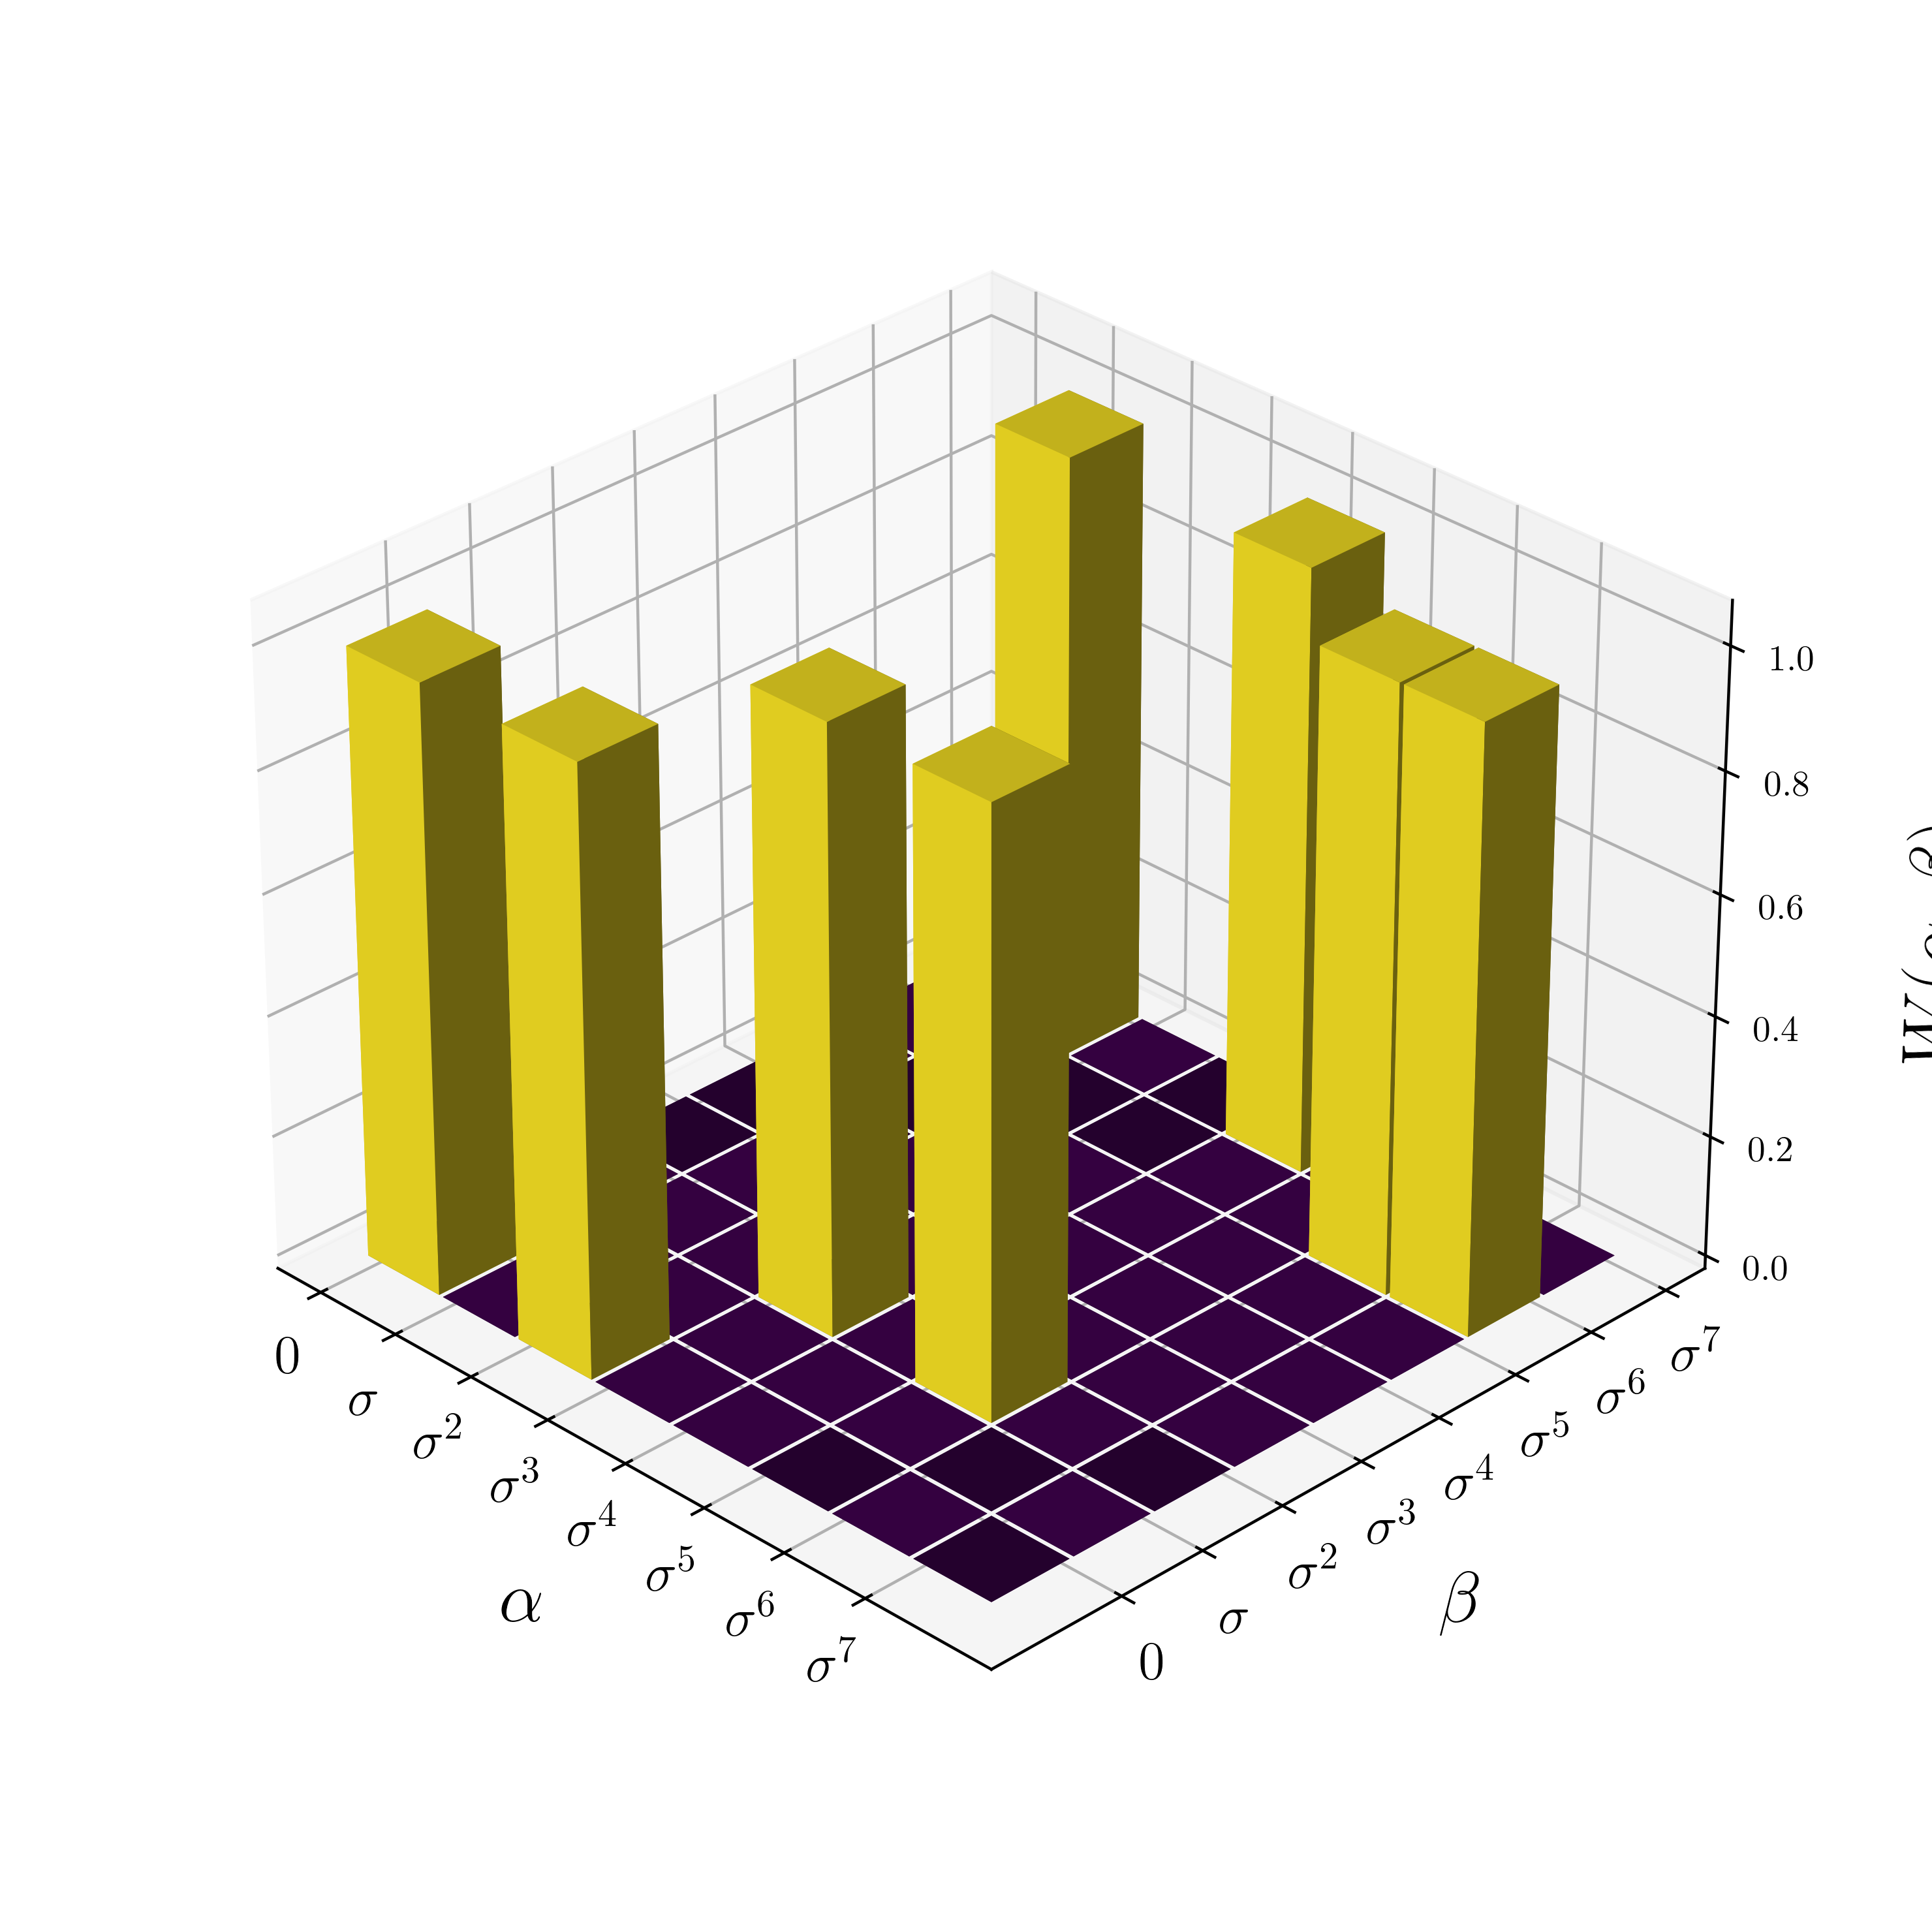

In [37]:
fig, ax = PlotWigner(w * 2^N)

In [38]:
bbox = fig.bbox_inches.from_bounds(1, 0.5, 7, 6)
fig.savefig('./paper_graphs/abelian_2.eps', format='eps', bbox_inches=bbox)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


/var/folders/04/vcl1jrm14fg9v4p4_s66k4hm0000gn/T/ipykernel_2258/457068485.py:54: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


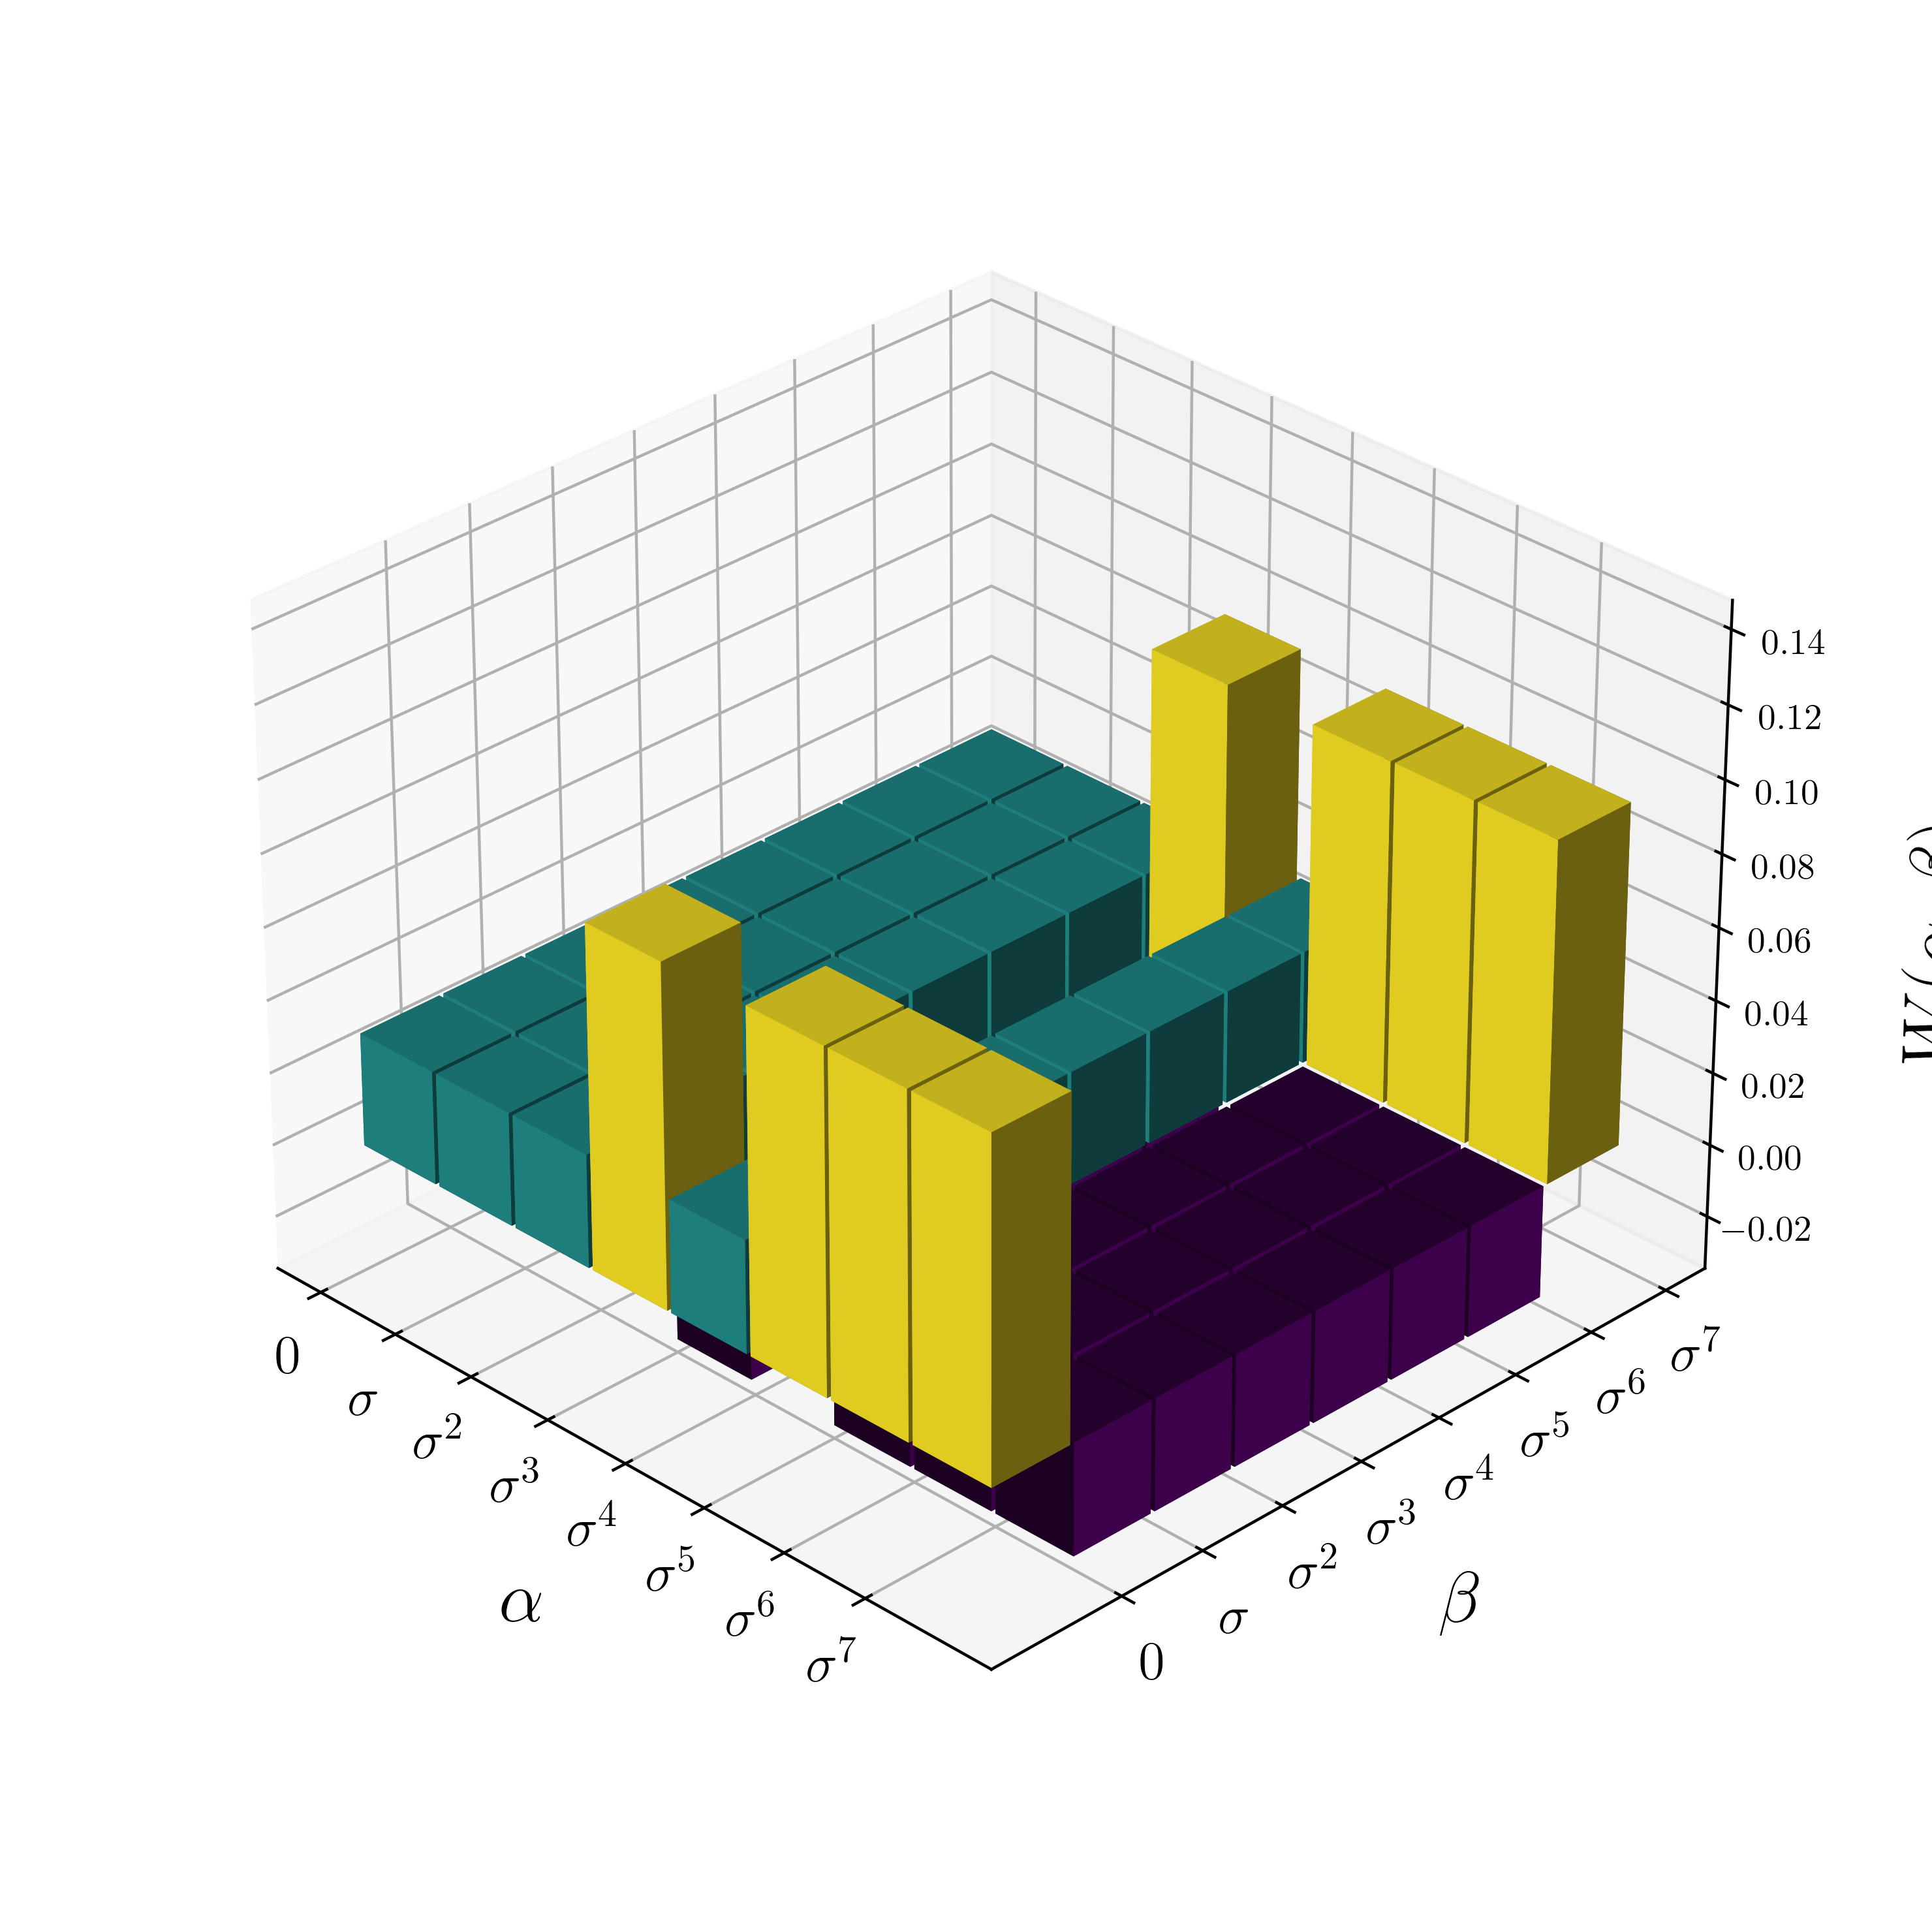

In [39]:
# GHZ state
s = Proj((Id[:,0] + Id[:,-1])/np.sqrt(2))
w = W(s)
fig, ax = PlotWigner(w)

In [40]:
bbox = fig.bbox_inches.from_bounds(1, 0.5, 7, 6)
fig.savefig('./paper_graphs/ghz.eps', format='eps', bbox_inches=bbox)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


---
Now as example we calculate the Wigner function for a non abelian curve from the same bundle, specifically the curves are given by:
$$
\alpha = \sigma^6 \beta + \sigma^3 \beta^2 + \sigma^5 \beta^4,
\quad
\beta = \sigma^2 \alpha + \sigma^3 \alpha^2 + \sigma^5 \alpha^4.
$$

In [41]:
curve3 = lambda b: (x^6 * b + x^3 * b^2 + x^5 * b^4, b)
curve4 = lambda a: (a, x^2 * a + x^3 * a^2 + x^5 * a^4)

In [50]:
curve = lambda a: x^2 * a + x^3 * a^2 + x^5 * a^4
sols = sign_perm(solve_basis(basis, curve), [1,1,1])
for k in F:
    for kp in F:
        lhs = c(k, curve, sols) * c(kp, curve, sols)
        rhs = chi2(kp * curve(k)) * c(k + kp, curve, sols)
        if lhs != rhs:
            raise Exception('Recurrence relation does not hold!', mu)
print('Recurrence relation holds!')

Recurrence relation holds!


In [51]:
# phases for non-abelian curve (40) with positive signs
for k in F:
    print(complex(c(k, curve, sols)))

(1+0j)
(1+0j)
1j
(1+0j)
1j
1j
1j
(1+0j)


In [52]:
def D2(tau, curve, sols):
    return complex(c(tau, curve, sols)) * (Z(tau) @ X(curve(tau)))

In [53]:
# abelian condition for correct phases
for t1 in F:
    for t2 in F:
        p_op = D2(t1, curve, sols) @ D2(t2, curve, sols)
        s_op = D2(t1+t2, curve, sols)
        if not np.allclose(p_op, s_op):
                raise Exception(p1, p2)

We've got the curve phases for a non-abelian curve. These phases make it abelian in it's own right. Of course the don't match with the ray phases:

In [54]:
# Curve phases
for k in F:
    print(complex(c(k, curve, sols)))

(1+0j)
(1+0j)
1j
(1+0j)
1j
1j
1j
(1+0j)


In [55]:
# Ray phases for [1,1,1]
for k in F:
    print(phi(k,curve(k)))

(1+0j)
(1+0j)
-1j
(1+0j)
-1j
1j
1j
(1+0j)


Now let's generate the eigenstate for the curve $(\alpha,\beta(\alpha))$.
$$
|\psi^{\alpha,\beta}_\kappa\rangle
= \frac{1}{p^N} \sum_{\tau} \chi(\kappa \tau) D_2(\alpha(\tau),\beta(\tau))
= \frac{1}{p^N} \sum_{\tau} \chi(\kappa \tau) D_2(\tau,\beta(\tau))
$$

In [56]:
k = F(0)
non_ab_state = np.zeros((2^N, 2^N), dtype='complex128')
for tau in F:
    non_ab_state += complex(chi(tau * k)) * D2(tau, curve, sols) / 1/2^N

In [57]:
non_ab_state.trace()

(0.9999999999999999+1.8369701987210294e-16j)

In [58]:
np.allclose(non_ab_state, non_ab_state.conj().T)

True

In [59]:
Matrix(np.round(non_ab_state, 3))

[   0.5  0.5*I    0.0    0.0    0.0    0.0    0.0    0.0]
[-0.5*I    0.5    0.0    0.0    0.0    0.0    0.0    0.0]
[   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0]
[   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0]
[   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0]
[   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0]
[   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0]
[   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0]

In [60]:
Matrix(np.round(D2(x^5, curve, sols) @ non_ab_state @ D2(x^2, curve, sols).conj().T, 3))

[   0.5  0.5*I    0.0    0.0    0.0    0.0    0.0    0.0]
[-0.5*I    0.5    0.0    0.0    0.0    0.0    0.0    0.0]
[   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0]
[   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0]
[   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0]
[   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0]
[   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0]
[   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0]

In [61]:
w = W(non_ab_state)

/var/folders/04/vcl1jrm14fg9v4p4_s66k4hm0000gn/T/ipykernel_2258/457068485.py:54: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


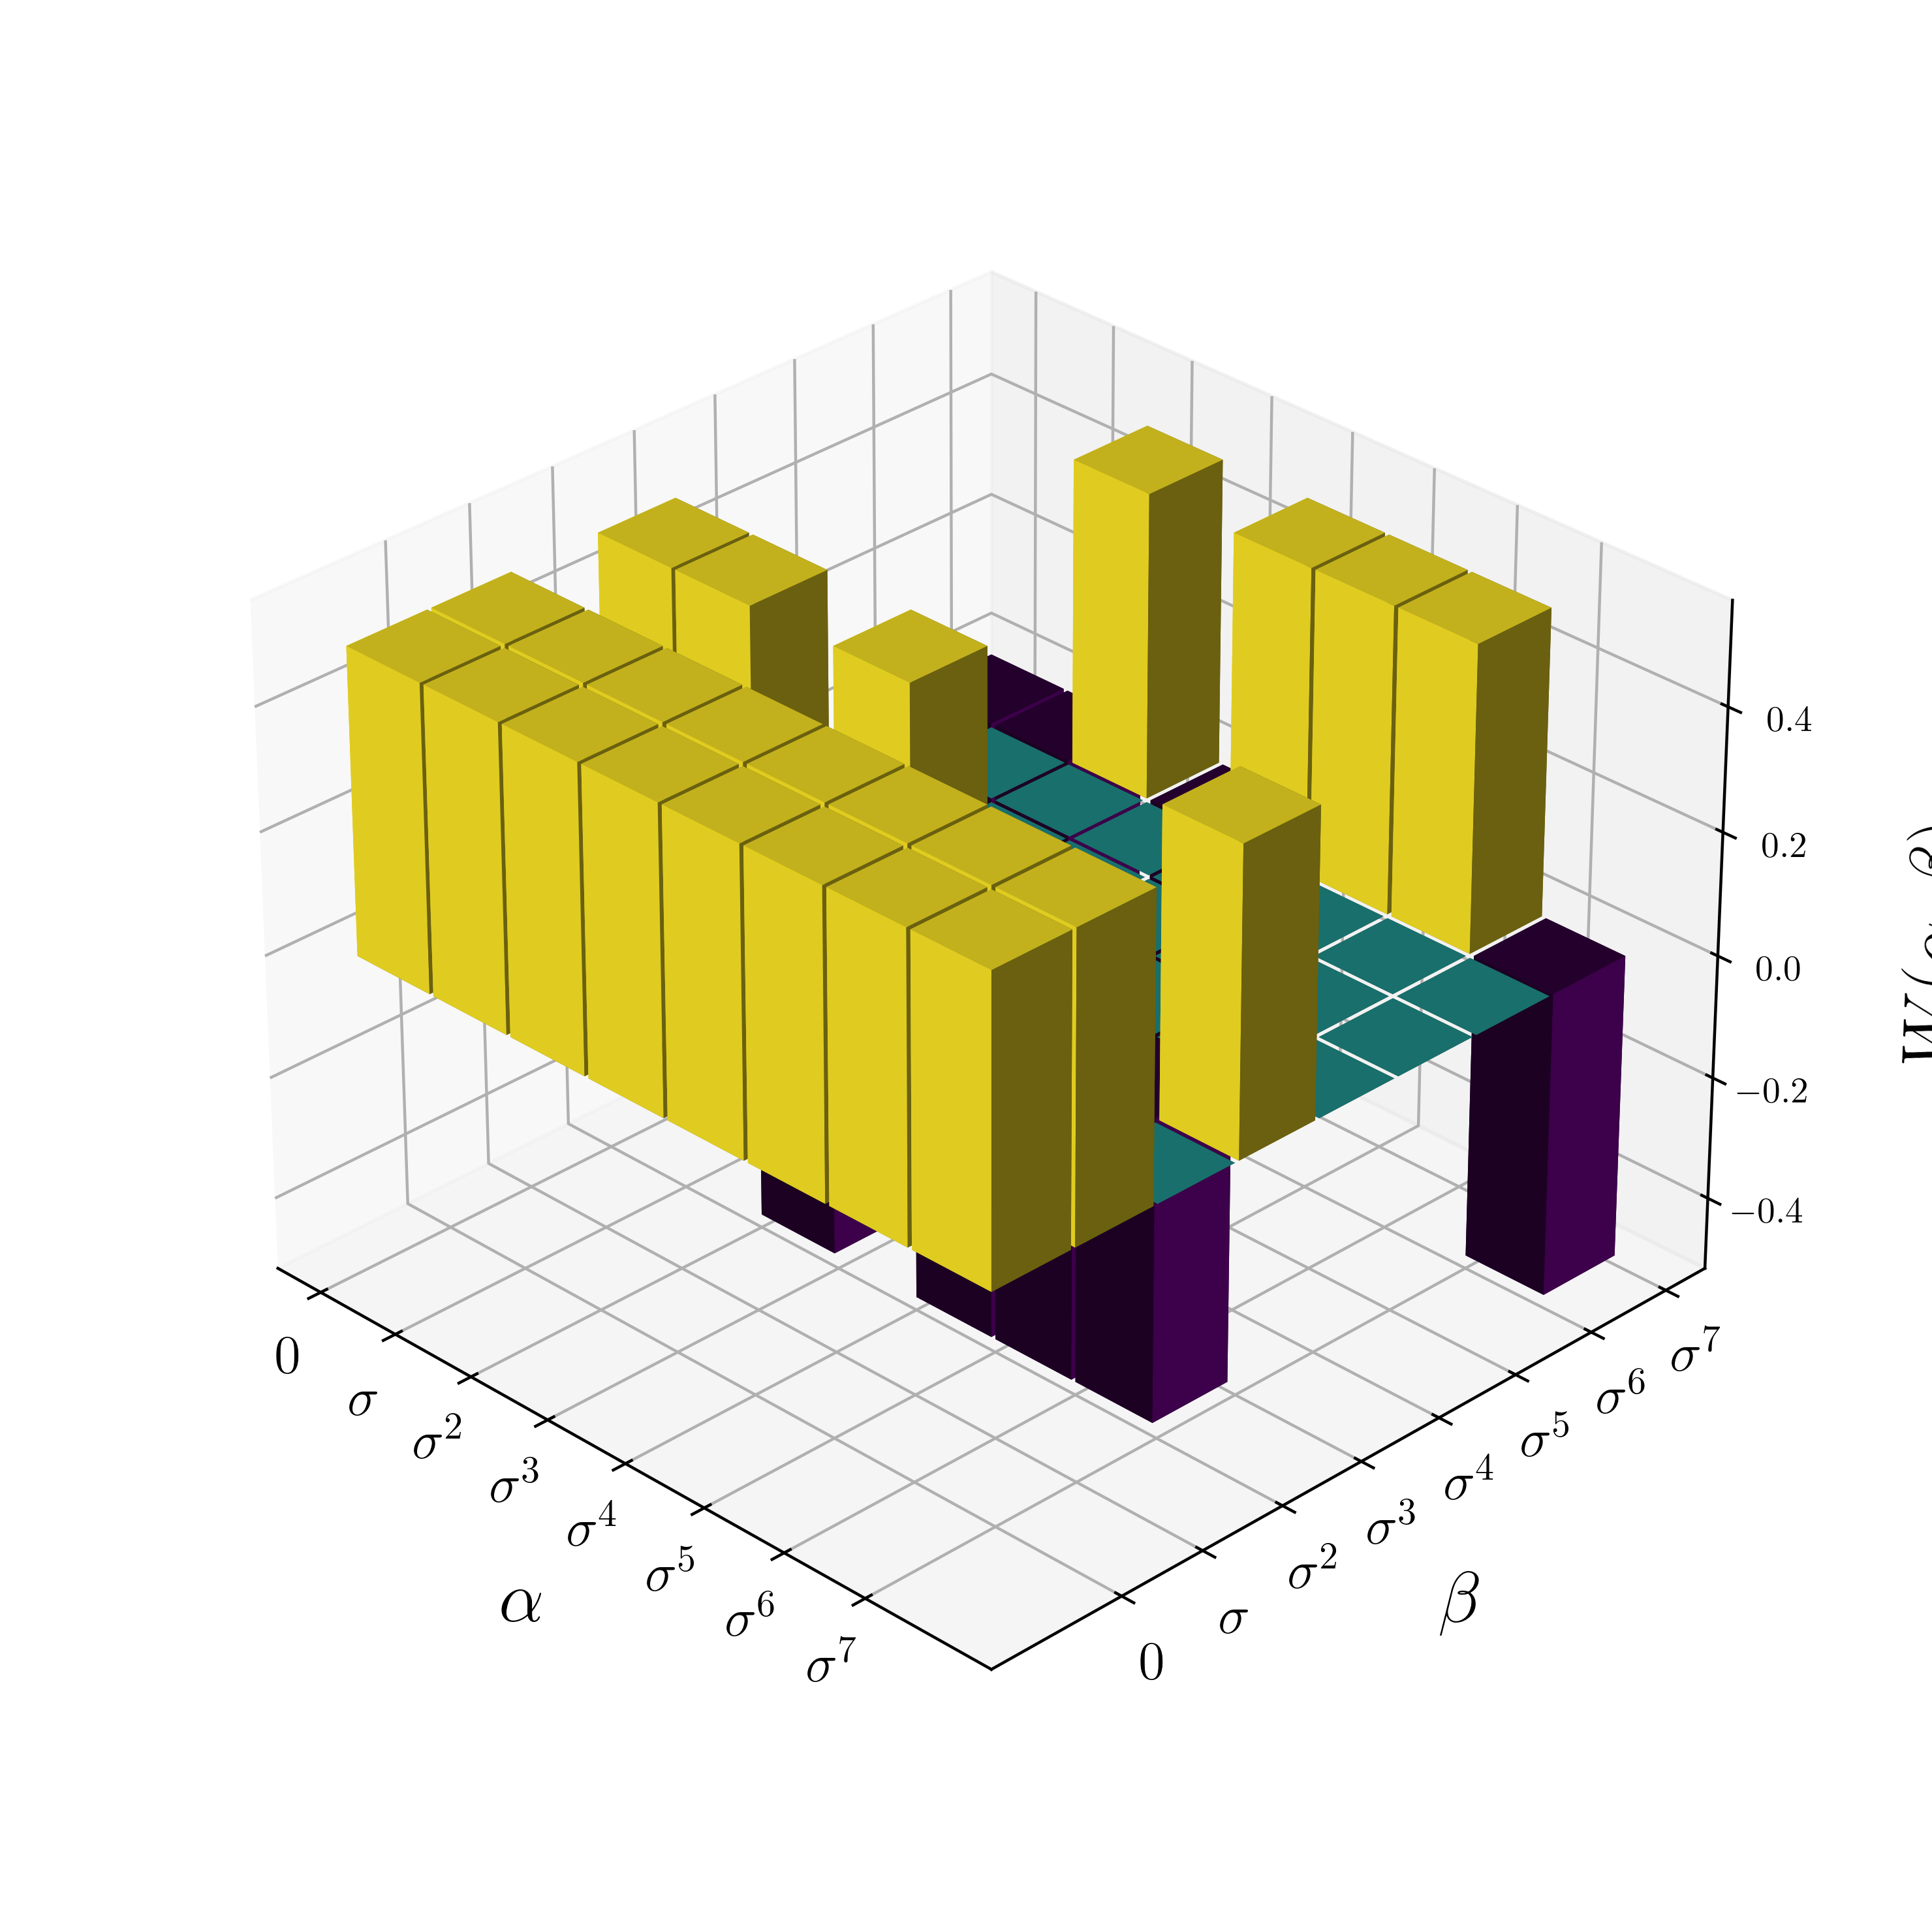

In [71]:
fig, ax = PlotWigner(w * 2^N)

In [70]:
w[-3,-1] = 0.062

In [74]:
bbox = fig.bbox_inches.from_bounds(1, 0.5, 7, 6)
fig.savefig('./paper_graphs/non_abelian_40_111.eps', format='eps', bbox_inches=bbox)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Now we search for a sign distribution of the curve that hits the ray phases. I don't think there is one, because if there is phase solution that matches with the rays phases, then it is by definition not a solution to the recurrence relation because the curve is not abelian.

In [234]:
curve = lambda a: x^2 * a + x^3 * a^2 + x^5 * a^4 # \beta = \mu \alpha

In [235]:
from itertools import product
for perm in product([1,-1], repeat=3):
    sols = sign_perm(solve_basis(basis, curve), perm)
    curve_phases = [complex(c(k, curve, sols)) for k in F]
    print(curve_phases)

[(1+0j), (1+0j), 1j, (1+0j), 1j, 1j, 1j, (1+0j)]
[(1+0j), (-1+0j), 1j, (1+0j), -1j, 1j, -1j, (-1+0j)]
[(1+0j), (-1+0j), -1j, (1+0j), 1j, -1j, 1j, (-1+0j)]
[(1+0j), (1+0j), -1j, (1+0j), -1j, -1j, -1j, (1+0j)]
[(1+0j), (1+0j), -1j, (-1+0j), -1j, 1j, 1j, (-1+0j)]
[(1+0j), (-1+0j), -1j, (-1+0j), 1j, 1j, -1j, (1+0j)]
[(1+0j), (-1+0j), 1j, (-1+0j), -1j, -1j, 1j, (1+0j)]
[(1+0j), (1+0j), 1j, (-1+0j), 1j, -1j, -1j, (-1+0j)]


In [236]:
[ps[toInt(k), toInt(curve(k))] for k in F]

[(1+0j), (1+0j), -1j, (1+0j), -1j, 1j, 1j, (1+0j)]

In [177]:
# sanity check that the phases all make the 
# curve abelian as it should.
for perm in product([1,-1], repeat=3):
    print('Testing perm', perm)
    sols = sign_perm(solve_basis(basis, curve), perm)
    print('Phases', [c(k, curve, sols) for k in F])
    for t1 in F:
        for t2 in F:
            dop1 = complex(c(t1, curve, sols)) * Z(t1) @ X(curve(t1))
            dop2 = complex(c(t2, curve, sols)) * Z(t2) @ X(curve(t2))
            dop3 = complex(c(t1+t2, curve, sols)) * Z(t1+t2) @ X(curve(t1+t2))
            if not np.allclose(dop1 @ dop2,  dop3):
                raise Exception(t1, t2)

Testing perm (1, 1, 1)
Phases [1, 1, I, 1, I, I, I, 1]
Testing perm (1, 1, -1)
Phases [1, -1, I, 1, -I, I, -I, -1]
Testing perm (1, -1, 1)
Phases [1, -1, -I, 1, I, -I, I, -1]
Testing perm (1, -1, -1)
Phases [1, 1, -I, 1, -I, -I, -I, 1]
Testing perm (-1, 1, 1)
Phases [1, 1, -I, -1, -I, I, I, -1]
Testing perm (-1, 1, -1)
Phases [1, -1, -I, -1, I, I, -I, 1]
Testing perm (-1, -1, 1)
Phases [1, -1, I, -1, -I, -I, I, 1]
Testing perm (-1, -1, -1)
Phases [1, 1, I, -1, I, -I, -I, -1]


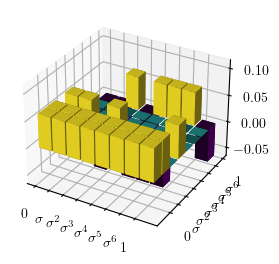

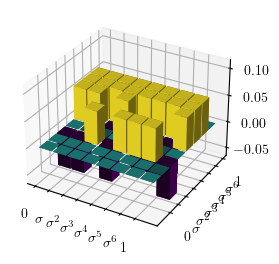

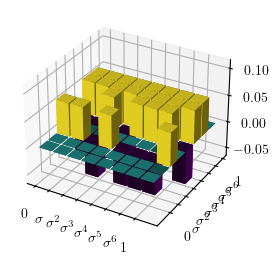

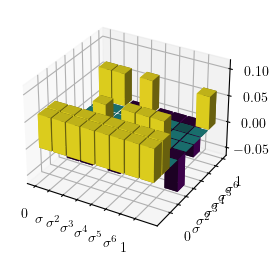

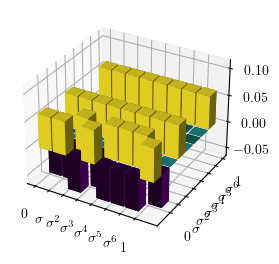

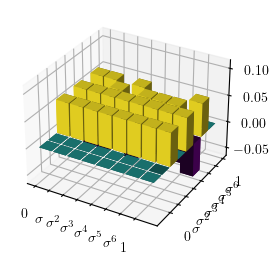

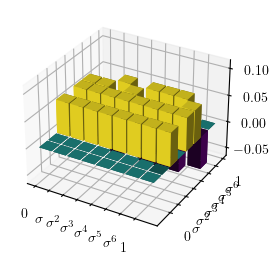

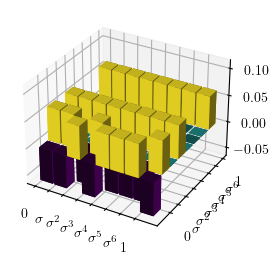

In [178]:
for perm in product([1,-1], repeat=3):
    sols = sign_perm(solve_basis(basis, curve), perm)
    k = F(0)
    non_ab_state = np.zeros((2^N, 2^N), dtype='complex128')
    for tau in F:
        non_ab_state += complex(chi(tau * k)) * D2(tau, curve, sols) / 1/2^N
    PlotWigner(W(non_ab_state), (3,3))

---
As expected there is no sign distribution for the curve that makes it match up with the rays phases. But now I think what Klimov wants is to see if there is a ray phase space distribution such that the curve becomes abelian.

In [179]:
def PS(curve, perms):
    phase_space = zero_matrix(SR, 2^N, 2^N)
    phase_space[0,:] = 1 # vertical line
    for j, mu in enumerate(F): # iterate through the curve parametr
        # same sign choice for a fixed curve parameter
        sols = sign_perm(solve_basis(basis, curve(mu)), perms[j])
        for i, a in enumerate(F):
            # loop through alpha to obtain coefficient and
            # corresponding point
            coeff = c(a, curve(mu), sols)
            b = curve(mu)(a)
            phase_space[i, toInt(b)] = coeff
    return phase_space

In [180]:
def ray(mu):
    return lambda t: mu * t

In [182]:
for perm in product([1,-1], repeat=3):
    print('Testing perm:', perm)
    ps2 = PS(ray, [perm] * 8)
    # print(ps2)
    
    def D3(a, b):
        return complex(ps2[toInt(a), toInt(b)]) * (Z(a) @ X(b))

    points = [(k, curve(k)) for k in F]
    print([ps2[toInt(a),toInt(b)] for a, b in points])
    try:
        for p1 in points:
            for p2 in points:
                p_op = D3(*p1) @ D3(*p2)
                s_op = D3(p1[0] + p2[0], p1[1] + p2[1])
                if not np.allclose(p_op, s_op):
                    raise Exception(p1, p2)
        print('Found distribution for which curve is abelian!', perm)
    except:
        print('Not abelian!!')

Testing perm: (1, 1, 1)
[1, 1, -I, 1, -I, I, I, 1]
Not abelian!!
Testing perm: (1, 1, -1)
[1, -1, -I, 1, I, I, -I, -1]
Not abelian!!
Testing perm: (1, -1, 1)
[1, -1, I, 1, -I, -I, I, -1]
Not abelian!!
Testing perm: (1, -1, -1)
[1, 1, I, 1, I, -I, -I, 1]
Not abelian!!
Testing perm: (-1, 1, 1)
[1, 1, I, -1, I, I, I, -1]
Not abelian!!
Testing perm: (-1, 1, -1)
[1, -1, I, -1, -I, I, -I, 1]
Not abelian!!
Testing perm: (-1, -1, 1)
[1, -1, -I, -1, I, -I, I, 1]
Not abelian!!
Testing perm: (-1, -1, -1)
[1, 1, -I, -1, -I, -I, -I, -1]
Not abelian!!


Sainz found a DPS for which the non-abelian curve (40) becomes abelian.

In [183]:
ps2 = PS(ray, [[1,1,1]] + ([[-1,-1,-1]] * 7))
ps2

[ 1  1  1  1  1  1  1  1]
[ 1 -1 -I  1 -I  I  I -1]
[ 1 -I -1  I -I  I  1 -1]
[ 1 -1 -I -I -I -1 -1 -I]
[ 1 -I -I  I -1  1  I -1]
[ 1 -I -I -1 -1 -I -1 -I]
[ 1 -I -1 -1 -I -1 -I -I]
[ 1  1  1 -I  1 -I -I  I]

In [184]:
def D3(a, b):
    return complex(ps2[toInt(a), toInt(b)]) * (Z(a) @ X(b))

In [186]:
# curve is now abelian
for p1 in points:
    for p2 in points:
        p_op = D3(*p1) @ D3(*p2)
        s_op = D3(p1[0] + p2[0], p1[1] + p2[1])
        if not np.allclose(p_op, s_op):
            raise Exception(p1, p2)

On the other hand, if the curve is abelian, then we should be able to generate a phase that matches up to the phases given by the DPS.

In [187]:
ab_curve = lambda a: a + x^3 * a^2 + x^5 * a^4

In [188]:
graph([(a,ab_curve(a)) for a in F])

[1 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 1]
[1 0 0 0 0 0 0 0]
[0 0 1 0 0 0 0 0]
[0 0 0 0 0 0 0 1]
[0 0 1 0 0 0 0 0]
[0 0 0 0 0 0 1 0]
[0 0 0 0 0 0 1 0]

In [189]:
for perm in product([1,-1], repeat=3):
    print('Testing perm', perm)
    sols = sign_perm(solve_basis(basis, ab_curve), perm)
    print('Phases', [c(k, ab_curve, sols) for k in F])
    for t1 in F:
        for t2 in F:
            dop1 = complex(c(t1, ab_curve, sols)) * Z(t1) @ X(ab_curve(t1))
            dop2 = complex(c(t2, ab_curve, sols)) * Z(t2) @ X(ab_curve(t2))
            dop3 = complex(c(t1+t2, ab_curve, sols)) * Z(t1+t2) @ X(ab_curve(t1+t2))
            if not np.allclose(dop1 @ dop2,  dop3):
                raise Exception(t1, t2)

Testing perm (1, 1, 1)
Phases [1, -1, 1, I, -1, I, I, I]
Testing perm (1, 1, -1)
Phases [1, 1, 1, I, 1, I, -I, -I]
Testing perm (1, -1, 1)
Phases [1, 1, -1, I, -1, -I, I, -I]
Testing perm (1, -1, -1)
Phases [1, -1, -1, I, 1, -I, -I, I]
Testing perm (-1, 1, 1)
Phases [1, -1, -1, -I, 1, I, I, -I]
Testing perm (-1, 1, -1)
Phases [1, 1, -1, -I, -1, I, -I, I]
Testing perm (-1, -1, 1)
Phases [1, 1, 1, -I, 1, -I, I, I]
Testing perm (-1, -1, -1)
Phases [1, -1, 1, -I, -1, -I, -I, -I]


In [190]:
[ps[toInt(k), toInt(ab_curve(k))] for k in F]

[(1+0j), (-1+0j), (1+0j), 1j, (-1+0j), 1j, 1j, 1j]

As we can see it turns out that the phase for the all positive solution for the curve matches the phases of the DPS! Also it is the only solution that does so, I wonder if there is a direct relationship with the choice of DPS and the choice of phases of the curve.

Just as in equation (40) Sainz says that we can turn the following curve:
$$\alpha = \sigma^2 \beta + \sigma^3 \beta^2 + \sigma^5 \beta^4,$$
into an abelian curve by choosing a specific DPS.

In [234]:
curve090_na = lambda b: (x^2 * b + x^3 * b^2 + x^5 * b^4, b)

In [237]:
points = [curve090_na(a) for a in F]

In [238]:
graph(points)

[1 1 0 1 0 0 0 1]
[0 0 1 0 1 1 1 0]
[0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0]

The specific DPS that Sainz uses is the all positive solutions for the basis elements for all slopes $\mu$ except for $\mu = \sigma^4$ and $\mu = \sigma^5$. For both of these slopes, we choose the negative sign for the the basis elements $\sigma^5$ and $\sigma^6$.

In [240]:
list(F)

[0, x, x^2, x + 1, x^2 + x, x^2 + x + 1, x^2 + 1, 1]

In [256]:
perms = ([[1,1,1]] * 4) + ([[1,-1,1]] * 2) + ([[1,1,1]] * 2)
perms

[[1, 1, 1],
 [1, 1, 1],
 [1, 1, 1],
 [1, 1, 1],
 [1, -1, 1],
 [1, -1, 1],
 [1, 1, 1],
 [1, 1, 1]]

In [262]:
ps3 = PS(ray, perms)
ps3

[ 1  1  1  1  1  1  1  1]
[ 1 -1 -I  1 -I -I -I -1]
[ 1 -I -1  I -I  I -1  1]
[ 1  1  I  I  I  1  1  I]
[ 1 -I -I  I -1  1  I -1]
[ 1  I -I -1  1  I  1  I]
[ 1  I  1  1  I  1  I  I]
[ 1 -1 -1  I  1 -I  I -I]

In [265]:
def D4(a,b):
    return complex(ps3[toInt(a), toInt(b)]) * (Z(a) @ X(b))

for p1 in points:
    for p2 in points:
        p_op = D4(*p1) @ D4(*p2)
        s_op = D4(p1[0] + p2[0], p1[1] + p2[1])
        if not np.allclose(p_op, s_op):
            raise Exception(p1, p2)

---
Finally let's modify the calculation of the phase coefficients so it can work for all parametrized curves and not just regular curves of the form $\beta = f(\alpha)$.

In [124]:
y = var('y')

# compute the coefficients for the basis elements,
def solve_basis(basis, curve):
    sols = []
    for k in basis:
        sol = solve(chi2(k * curve(k)) == y^2, y, solution_dict=True)
        sols.append(sol[1]) # positive solutions only (choice)
    return sols

In [125]:
# after computing the solutions we can simply
# get them for each basis element.
def basis_c(a, l, sols):
    if a == 0:
        return 1
    return sols[l][y]

In [126]:
# Compute an arbitrary coefficient c_{\alpha,f(\alpha)} for a 
# given curve f using the general formula.
def c(alpha, curve, sols=None):
    if not sols:
        sols = solve_basis(basis, curve)
    
    # Expand alpha in the basis
    comps = components(alpha)

    # Apply the formula
    s1 = 0
    for k in range(N-1):
        s2 = 0
        for j in range(k+1, N):
            s2 += comps[j] * basis[j]
        s1 += s2 * curve(comps[k] * basis[k])
        
    return chi2(s1) * prod([basis_c(a, l, sols) for l, a in enumerate(comps)])

In [127]:
def sign_perm(sols, perm=None):
    if perm:
        for k, sol in enumerate(sols):
            sols[k][y] = perm[k] * sols[k][y]
    return sols

In [128]:
# def phi(a, b):
#     return ps[toInt(a), toInt(b)]

# def Z(a):
#     return np.diag([chi(a * k) for k in F])

# def X(b):
#     return FF.conj().T @ Z(b) @ FF

# def D(a, b):
#     return phi(a, b) * (Z(a) @ X(b))

In [ ]:
# non-abelian curves
curve3 = lambda b: (x^6 * b + x^3 * b^2 + x^5 * b^4, b)
curve4 = lambda a: (a, x^2 * a + x^3 * a^2 + x^5 * a^4)

---

Quantum state tomography. Simply calculate the probabilities:
$$
p_\kappa^{(\lambda)} = \bra{\psi_\kappa^\lambda} \hat\rho \ket{\psi_\kappa^\lambda},
$$
in order to express the state $\hat\rho$ as a decomposition of the projection operators $\ket{\psi_\kappa^\lambda}\bra{\psi_\kappa^\lambda}$:
$$
\hat\rho = \sum_{\kappa,\lambda} p_\kappa^{(\lambda)} \ket{\psi_\kappa^\lambda}\bra{\psi_\kappa^\lambda} - \hat I.
$$

In [148]:
# GHZ state
rho = Proj((Id[:,0] + Id[:,-1]) / sqrt(2))
Matrix(rho)

[0.5 0.0 0.0 0.0 0.0 0.0 0.0 0.5]
[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
[0.5 0.0 0.0 0.0 0.0 0.0 0.0 0.5]

In [156]:
rho_reconst = np.zeros((8,8), dtype='complex128')
# parametrized lines
for mu in F:
    for k in F:
        op = eig_proj(ray(mu), k)
        p_l_k = complex((op @ rho).trace())
        rho_reconst += p_l_k * op
# vertical line
for k in range(len(F)):
    op = Proj(FF[:,k])
    p_l_k = complex((op @ rho).trace())
    rho_reconst += p_l_k * op
rho_reconst -= Id

In [157]:
Matrix(np.round(rho_reconst, 4))

[0.5 0.0 0.0 0.0 0.0 0.0 0.0 0.5]
[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
[0.5 0.0 0.0 0.0 0.0 0.0 0.0 0.5]

In [158]:
# matrix of measurements
meas = np.zeros((9,8), dtype='complex128')
for i, l in enumerate(F):
    for j, k in enumerate(F):
        meas[i,j] = complex((eig_proj(ray(l), k) @ rho).trace())
for j, k in enumerate(F):
    meas[-1,j] = complex((Proj(FF[:,j]) @ rho).trace())

In [159]:
Matrix(np.round(meas, 3))

[  0.5   0.0   0.0   0.0   0.0   0.0   0.0   0.5]
[0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
[0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
[  0.0  0.25  0.25  0.25   0.0   0.0  0.25   0.0]
[0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
[  0.0  0.25   0.0  0.25  0.25  0.25   0.0   0.0]
[  0.0   0.0  0.25   0.0  0.25  0.25  0.25   0.0]
[0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
[ 0.25  0.25  0.25   0.0  0.25   0.0   0.0   0.0]